These are my notes on how `torch.nn.functional.grid_sampler` works, focusing specifically on the behavior of the `align_corners` and `padding_mode` arguments.

I needed to understand these things in order to write a Metal implementation.

In [1]:
import torch
import matplotlib.pyplot as plt
import math

In [2]:
def kurt_grid_sampler1d(input, grid, *, align_corners=False, padding_mode='zeros'):
    # We need to map the `grid` coordinates onto a new coordinate system where a
    # coordinate value of `n` refers to the n-th value of the input. Then it
    # will be relatively simple to use those transformed coordinates to find the
    # pair of `input` values which surround each coordinate, and then
    # interpolate between them.
    #
    # For the case of `align_corners=True`, a `grid` coordinate of -1 always
    # represents the leftmost value of `input`, and coordinate 1 always
    # represents the rightmost. So to map onto the new coordinate system, we
    # just need to shift all coordinates to the right by 1, divide by 2, and
    # multiply by the length of the input.
    # 
    # But when `align_corners=False`, coordinate -1 corresponds to the midpoint
    # between the leftmost value of `input` and a fictitious padding value to
    # its left. Ditto for the right side. So we first have to map the unaligned
    # coordinate system onto the aligned coordinate system. In other words,
    # whatever unaligned coordinate value corresponds to the leftmost and
    # rightmost values in the input (which changes depending on the size of the
    # input) will get mapped onto the aligned cooridinate values -1 and 1,
    # respectively.

    N = input.shape[0]

    if not align_corners:
        aligned_scale_length = N - 1
        unaligned_scale_length = aligned_scale_length + 1
        corner_alignment_factor = unaligned_scale_length / aligned_scale_length
        grid = grid * corner_alignment_factor

    grid = (grid + 1) * ((N - 1) / 2)

    # Now that we've mapped the coordinates onto a more intuitive coordinate
    # system, we can interpolate each output separately (since we'll do all of
    # this in Metal code).
    output = torch.empty_like(grid)

    def input_index_to_val(idx):
        if idx < 0 or idx >= N:
            if padding_mode == 'zeros':
                return 0
            elif padding_mode == 'border':
                if idx < 0:
                    return input[0]
                else:
                    return input[-1]
            elif padding_mode == 'reflection':
                M = (N - 1) if align_corners else N
                idx_reflect = idx % M
                
                if (idx // M) % 2 == 1:
                    idx_reflect = (N - 1) - idx_reflect

                return input[idx_reflect]
            else:
                raise RuntimeError
        else:
            return input[idx]

    for out_idx, coord in enumerate(grid):
        left_idx = math.floor(coord)
        right_idx = math.ceil(coord)
        scale = coord - left_idx

        left_val = input_index_to_val(left_idx)
        right_val = input_index_to_val(right_idx)

        output[out_idx] = left_val + (right_val - left_val) * scale

    return output

In [3]:
print(kurt_grid_sampler1d(torch.tensor([2., 3.]), torch.tensor([-1., 1.]), align_corners=True))
print(kurt_grid_sampler1d(torch.tensor([2., 3.]), torch.tensor([-0.5, 0.5]), align_corners=False))
print(kurt_grid_sampler1d(torch.tensor([2., 3., 4.]), torch.tensor([-1., 0., 1.]), align_corners=True))
print(kurt_grid_sampler1d(torch.tensor([2., 3., 4.]), torch.tensor([-2 / 3, 0., 2 / 3]), align_corners=False))

tensor([2., 3.])
tensor([2., 3.])
tensor([2., 3., 4.])
tensor([2., 3., 4.])


In [4]:
device = 'cpu'
dtype = torch.float

def make_plot(input, space, **kwargs):
    grid = torch.stack([space, torch.zeros_like(space)], dim=-1)[None, None, :]
    r_torch = torch.nn.functional.grid_sample(
        input,
        grid,
        **kwargs,
    ).flatten()

    r_kurt = kurt_grid_sampler1d(input.flatten(), space, **kwargs)

    plt.plot(space, r_torch, label='torch')
    plt.plot(space, r_kurt, label='kurt')

    plt.title(f'input shape: {input.shape}\nkwargs: {kwargs}')
    plt.grid()
    ax = plt.gca()
    ticks = torch.linspace(space[0].item(), space[-1].item(), int((space[-1].item() - space[0].item()) / 0.5) + 1).tolist()
    ax.set_xticks(ticks)
    ax.tick_params(axis='x', labelrotation=90)
    plt.legend()
    plt.axis('square')
    plt.show()

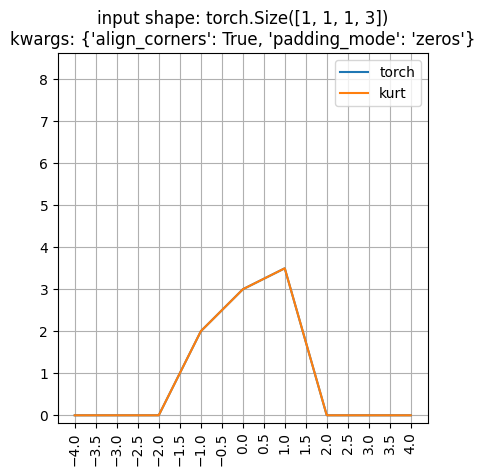

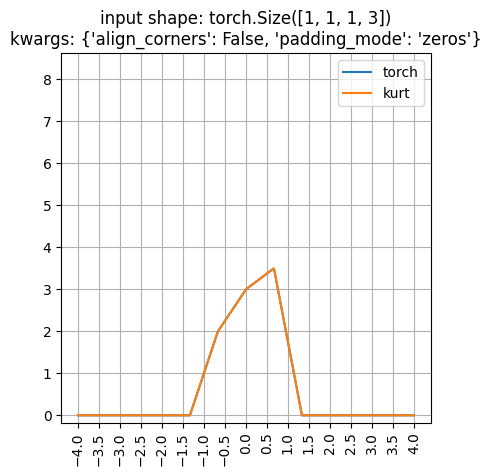

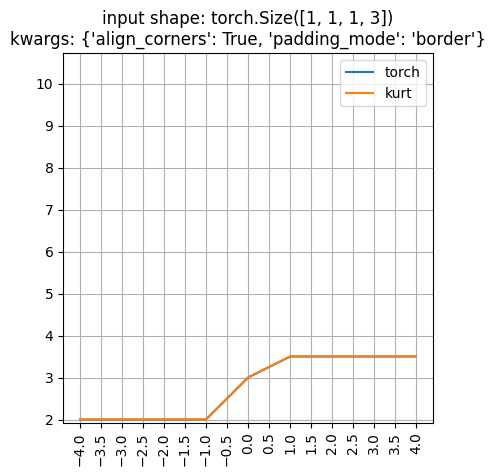

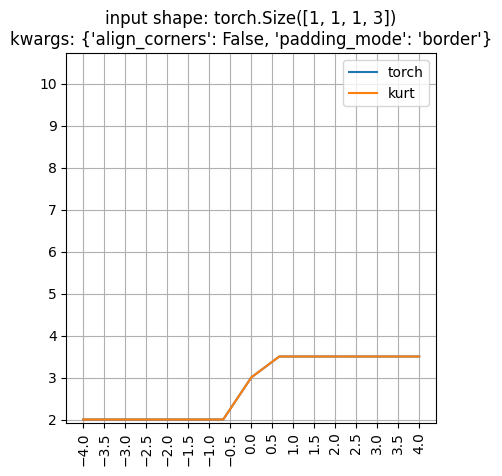

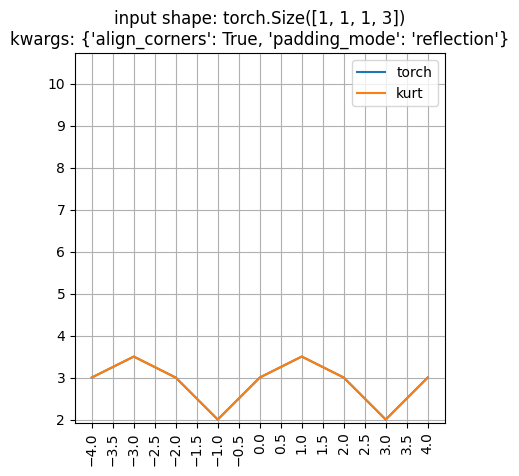

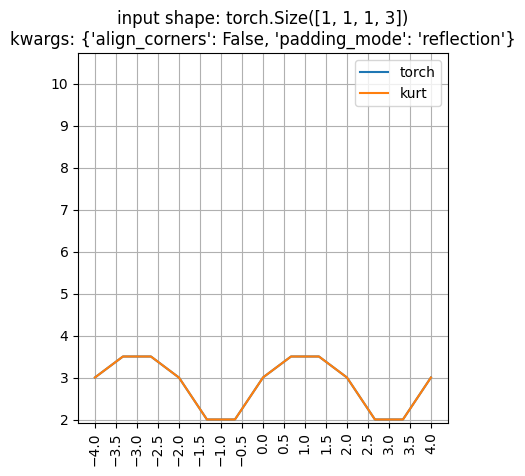

In [5]:
input = torch.tensor([[[[2, 3, 3.5]]]], dtype=dtype, device=device)
space = torch.linspace(-4, 4, 1000, dtype=torch.float, device=device)
make_plot(input, space, align_corners=True, padding_mode='zeros')
make_plot(input, space, align_corners=False, padding_mode='zeros')
make_plot(input, space, align_corners=True, padding_mode='border')
make_plot(input, space, align_corners=False, padding_mode='border')
make_plot(input, space, align_corners=True, padding_mode='reflection')
make_plot(input, space, align_corners=False, padding_mode='reflection')

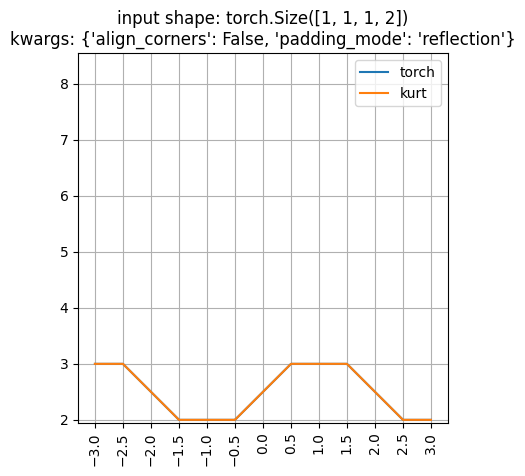

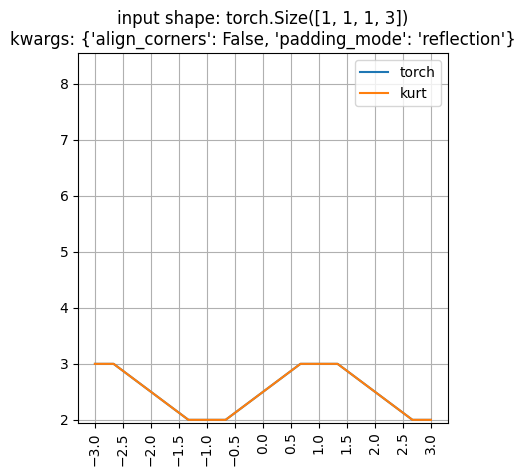

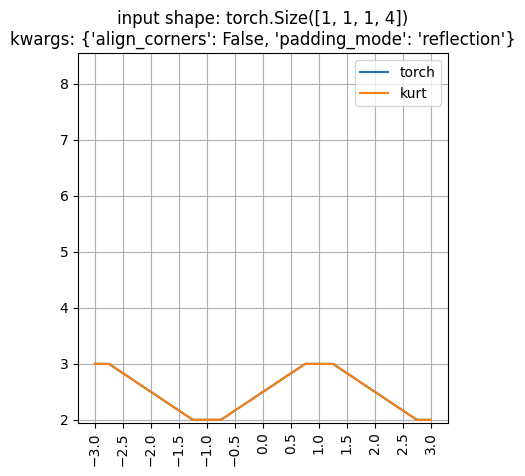

In [6]:
space = torch.linspace(-3, 3, 1000, dtype=torch.float, device=device)
input0 = torch.tensor([[[[2, 3]]]], dtype=dtype, device=device)
make_plot(input0, space, align_corners=False, padding_mode='reflection')
input1 = torch.tensor([[[[2, 2.5, 3]]]], dtype=dtype, device=device)
make_plot(input1, space, align_corners=False, padding_mode='reflection')
input2 = torch.tensor([[[[2, 2.333, 2.666, 3]]]], dtype=dtype, device=device)
make_plot(input2, space, align_corners=False, padding_mode='reflection')